In [1]:
from SPARQLWrapper import SPARQLWrapper, JSON
import networkx as nx
from pyvis.network import Network
from IPython.display import display, HTML

In [8]:
import requests

url = "http://localhost:9000"

sparql_query = """
PREFIX ub: <http://swat.cse.lehigh.edu/onto/univ-bench.owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
SELECT ?professor ?course WHERE {
    ?professor rdf:type ub:Professor .
    ?professor ub:teacherOf ?course .
}
"""

payload = {
    "username": "root",
    "password": "123456",
    "db_name": "lubm",
    "operation": "query",
    "format": "json",
    "sparql": sparql_query
}

headers = {
    "Content-Type": "application/json"
}

response = requests.post(url, json=payload, headers=headers)
print(response.json())


{'StatusCode': 1005, 'StatusMsg': 'Database not load yet.'}


In [21]:
import requests
from pyvis.network import Network

# gStore 接口地址
url = "http://localhost:9000"
label_uri = "http://www.wikidata.org/entity/Q1047508"  # Interscope Records

# SPARQL 查询
sparql_query = f"""
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?artist ?artistLabel ?work ?workLabel ?coArtist ?coArtistLabel
WHERE {{
  ?artist wdt:P264 <{label_uri}> .
  ?work wdt:P175 ?artist .
  OPTIONAL {{
    ?work wdt:P175 ?coArtist .
    FILTER(?coArtist != ?artist)
  }}
  OPTIONAL {{ ?artist rdfs:label ?artistLabel . FILTER(LANG(?artistLabel) = "en") }}
  OPTIONAL {{ ?work rdfs:label ?workLabel . FILTER(LANG(?workLabel) = "en") }}
  OPTIONAL {{ ?coArtist rdfs:label ?coArtistLabel . FILTER(LANG(?coArtistLabel) = "en") }}
}}
LIMIT 100
"""

payload = {
    "username": "root",
    "password": "123456",
    "db_name": "wikidata_music",
    "operation": "query",
    "format": "json",
    "sparql": sparql_query
}

headers = {
    "Content-Type": "application/json"
}

response = requests.post(url, json=payload, headers=headers)
data = response.json()

# 打印结果以供检查
print(data)

{'head': {'link': [], 'vars': ['artist', 'artistLabel', 'work', 'workLabel', 'coArtist', 'coArtistLabel']}, 'results': {'bindings': []}, 'StatusCode': 0, 'StatusMsg': 'success', 'AnsNum': 0, 'OutputLimit': 100, 'ThreadId': '139815928891072', 'QueryTime': '1'}


In [37]:
from pyvis.network import Network
import requests

# gStore 查询接口
url = "http://localhost:9000"
label_uri = "http://www.wikidata.org/entity/Q21077"  # Warner Music Group

# SPARQL 查询语句（不含共同艺人）
sparql_query = f"""
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?artist ?artistLabel ?work ?workLabel
WHERE {{
  ?artist wdt:P264 <{label_uri}> .
  ?work wdt:P175 ?artist .
  OPTIONAL {{ ?artist rdfs:label ?artistLabel . FILTER(LANG(?artistLabel) = "en") }}
  OPTIONAL {{ ?work rdfs:label ?workLabel . FILTER(LANG(?workLabel) = "en") }}
}}
LIMIT 50
"""

payload = {
    "username": "root",
    "password": "123456",
    "db_name": "wikidata_music",
    "operation": "query",
    "format": "json",
    "sparql": sparql_query
}

headers = {"Content-Type": "application/json"}

# 请求数据
try:
    response = requests.post(url, json=payload, headers=headers)
    results = response.json()
except Exception as e:
    print(f"❌ 请求失败：{e}")
    results = {"results": {"bindings": []}}

# 初始化 PyVis 网络图
# 初始化 PyVis 网络图
net = Network(height="800px", width="100%", bgcolor="#1e1e1e", font_color="white")
net.force_atlas_2based(gravity=-25, central_gravity=0.02, spring_length=200, spring_strength=0.05)

added_nodes = set()
bindings = results.get("results", {}).get("bindings", [])

if not bindings:
    print("⚠ 查询结果为空，未生成任何图谱。")

# 添加厂牌节点
net.add_node(label_uri, label="Warner Music Group", title=label_uri,
             color="#ff6666", shape="triangle", size=30)
added_nodes.add(label_uri)

# 构建图谱
for row in bindings:
    artist_uri = row["artist"]["value"]
    artist_label = row.get("artistLabel", {}).get("value", artist_uri)

    work_uri = row["work"]["value"]
    work_label = row.get("workLabel", {}).get("value", work_uri)

    # 添加艺术家节点
    if artist_uri not in added_nodes:
        net.add_node(artist_uri, label=artist_label, title=artist_uri,
                     color="#6fa8dc", shape="dot", size=20)
        added_nodes.add(artist_uri)

    # 添加作品节点
    if work_uri not in added_nodes:
        net.add_node(work_uri, label=work_label, title=work_uri,
                     color="#f6b26b", shape="box", size=15)
        added_nodes.add(work_uri)

    # 边连接
    net.add_edge(label_uri, artist_uri, title="signed with", color="#bbbbbb")
    net.add_edge(artist_uri, work_uri, title="performed", color="#ffffff")

# 展示图谱（改为 write_html）
try:
    output_file = "music_graph_simple.html"
    net.write_html(output_file)
    print(f"✅ 图谱 HTML 已生成：{output_file}（请手动用浏览器打开）")
except Exception as e:
    print(f"❌ 图谱生成失败：{e}")

✅ 图谱 HTML 已生成：music_graph_simple.html（请手动用浏览器打开）


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple

▶ 任务 Q1：厂牌 → 艺人
  gStore 时间: 2038.73 ms，结果数: 313
  MySQL 时间: 6.00 ms，结果数: 313

▶ 任务 Q2：厂牌 → 艺人 → 歌曲
  gStore 时间: 2070.74 ms，结果数: 5416
  MySQL 时间: 33.70 ms，结果数: 5416

▶ 任务 Q4：模糊匹配歌曲名包含 love
  gStore 时间: 2065.23 ms，结果数: 229
  MySQL 时间: 7.01 ms，结果数: 227

▶ 任务 Q5：统计每个厂牌的艺人数
  gStore 时间: 2067.79 ms，结果数: 15
  MySQL 时间: 1.98 ms，结果数: 15


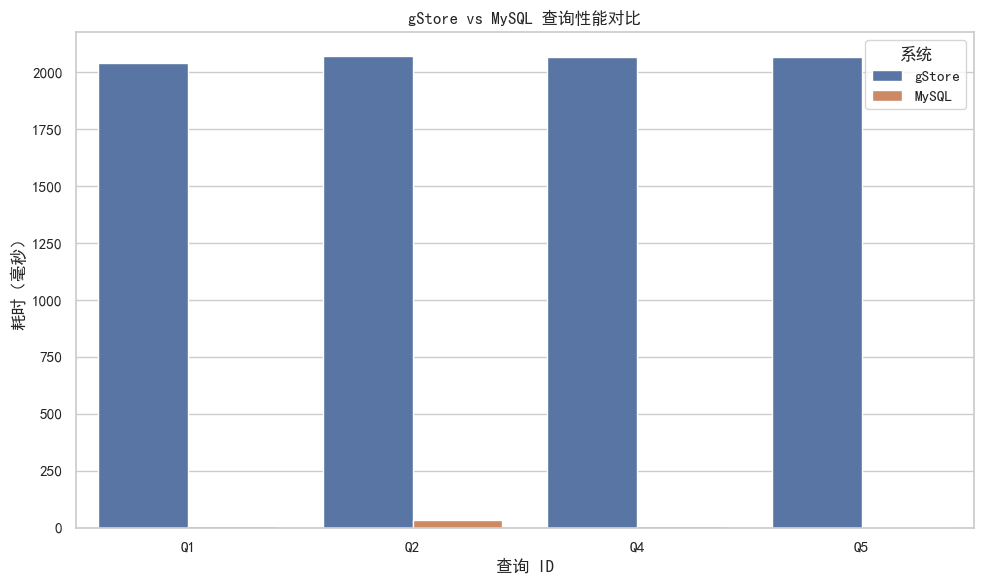

In [52]:
# 安装 seaborn（如未安装）
!pip install seaborn matplotlib pymysql requests

# === 导入库 ===
import requests
import time
import pymysql
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False    # 正确显示负号

# === MySQL 配置 ===
mysql_config = {
    "host": "localhost",
    "user": "root",
    "password": "root",
    "database": "wikidata_music",
    "charset": "utf8mb4",
    "cursorclass": pymysql.cursors.DictCursor
}

# === gStore 配置 ===
gstore_url = "http://localhost:9000"
gstore_payload_base = {
    "username": "root",
    "password": "123456",
    "db_name": "wikidata_music",
    "operation": "query",
    "format": "json"
}

# === 查询任务列表 ===
query_tasks = [
    {
        "id": "Q1",
        "desc": "厂牌 → 艺人",
        "sparql": """
            PREFIX wdt: <http://www.wikidata.org/prop/direct/>
            SELECT ?artist WHERE {
              ?artist wdt:P264 <http://www.wikidata.org/entity/Q21077> .
            }
        """,
        "sql": """
            SELECT a.artist_id, a.artist_name
            FROM artists a
            JOIN artist_label al ON a.artist_id = al.artist_id
            WHERE al.label_id = 'http://www.wikidata.org/entity/Q21077';
        """
    },
    {
        "id": "Q2",
        "desc": "厂牌 → 艺人 → 歌曲",
        "sparql": """
            PREFIX wdt: <http://www.wikidata.org/prop/direct/>
            SELECT ?artist ?work WHERE {
              ?artist wdt:P264 <http://www.wikidata.org/entity/Q21077> .
              ?work wdt:P175 ?artist .
            }
        """,
        "sql": """
            SELECT w.work_id, w.work_name
            FROM works w
            JOIN artist_work aw ON w.work_id = aw.work_id
            JOIN artist_label al ON aw.artist_id = al.artist_id
            WHERE al.label_id = 'http://www.wikidata.org/entity/Q21077';
        """
    },
    {
        "id": "Q4",
        "desc": "模糊匹配歌曲名包含 love",
        "sparql": """
            PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
            SELECT ?work ?label WHERE {
              ?work rdfs:label ?label .
              FILTER CONTAINS(LCASE(?label), "love")
            }
        """,
        "sql": "SELECT work_id, work_name FROM works WHERE LOWER(work_name) LIKE '%love%';"
    },
    {
        "id": "Q5",
        "desc": "统计每个厂牌的艺人数",
        "sparql": """
            PREFIX wdt: <http://www.wikidata.org/prop/direct/>
            SELECT ?label (COUNT(?artist) AS ?count) WHERE {
              ?artist wdt:P264 ?label .
            }
            GROUP BY ?label
        """,
        "sql": """
            SELECT al.label_id, COUNT(*) AS count
            FROM artist_label al
            GROUP BY al.label_id;
        """
    },
]

# === 运行测试函数 ===
def run_tests():
    results = []
    connection = pymysql.connect(**mysql_config)

    for task in query_tasks:
        print(f"\n▶ 任务 {task['id']}：{task['desc']}")

        # gStore 查询
        sparql_payload = gstore_payload_base.copy()
        sparql_payload["sparql"] = task["sparql"]

        try:
            t1 = time.time()
            r = requests.post(gstore_url, json=sparql_payload)
            t2 = time.time()
            sparql_result = r.json()
            gstore_count = len(sparql_result.get("results", {}).get("bindings", []))
            gstore_time = (t2 - t1) * 1000
        except Exception as e:
            print(f"❌ gStore 查询失败：{e}")
            gstore_time = -1
            gstore_count = 0

        # MySQL 查询
        try:
            with connection.cursor() as cursor:
                t3 = time.time()
                cursor.execute(task["sql"])
                mysql_result = cursor.fetchall()
                t4 = time.time()
                mysql_time = (t4 - t3) * 1000
                mysql_count = len(mysql_result)
        except Exception as e:
            print(f"❌ MySQL 查询失败：{e}")
            mysql_time = -1
            mysql_count = 0

        # 打印并记录结果
        print(f"  gStore 时间: {gstore_time:.2f} ms，结果数: {gstore_count}")
        print(f"  MySQL 时间: {mysql_time:.2f} ms，结果数: {mysql_count}")

        results.append({
            "query_id": task["id"],
            "description": task["desc"],
            "gstore_time_ms": gstore_time,
            "mysql_time_ms": mysql_time,
            "gstore_result_count": gstore_count,
            "mysql_result_count": mysql_count
        })

    connection.close()
    return results

# === 保存结果为 CSV ===
def save_results_csv(results, filename="performance_comparison.csv"):
    df = pd.DataFrame(results)
    df.to_csv(filename, index=False)
    print(f"\n📄 结果已保存为 {filename}")

# === 可视化对比图 ===
def plot_comparison(results):
    df = pd.DataFrame(results)
    df_melt = pd.melt(df, id_vars=["query_id", "description"],
                      value_vars=["gstore_time_ms", "mysql_time_ms"],
                      var_name="System", value_name="Time (ms)")

    system_map = {
        "gstore_time_ms": "gStore",
        "mysql_time_ms": "MySQL"
    }
    df_melt["System"] = df_melt["System"].map(system_map)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_melt, x="query_id", y="Time (ms)", hue="System")
    plt.title("gStore vs MySQL 查询性能对比")
    plt.xlabel("查询 ID")
    plt.ylabel("耗时（毫秒）")
    plt.legend(title="系统")
    plt.tight_layout()
    plt.show()

# === 执行主流程 ===
results = run_tests()
# save_results_csv(results)
plot_comparison(results)


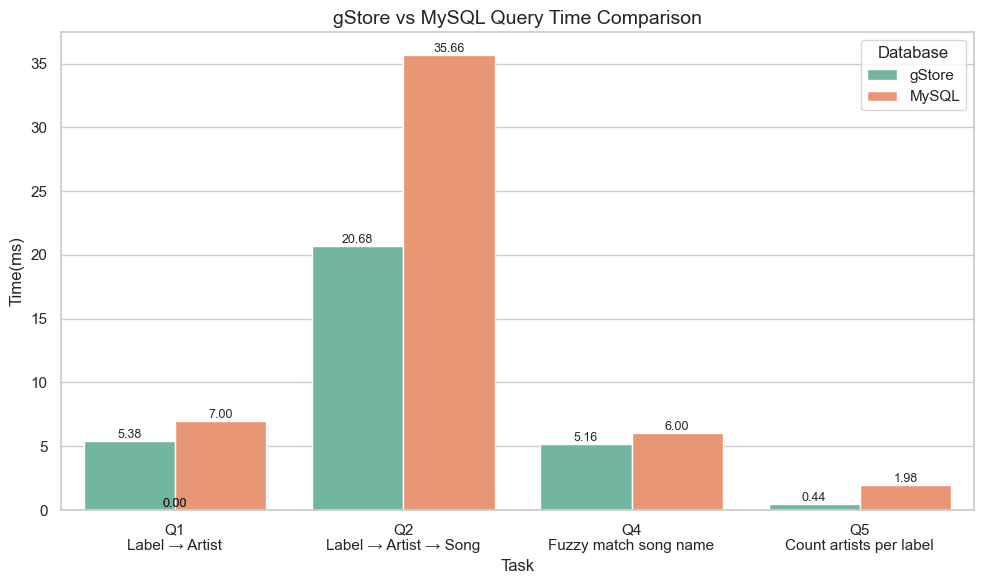

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set Chinese font (no longer needed since we're using English)
# plt.rcParams['font.sans-serif'] = ['SimHei']  # Use Hei font
# plt.rcParams['axes.unicode_minus'] = False  # Fix minus sign display

# Query task data
data = [
    {"Task": "Q1\nLabel → Artist", "gStore": 5.38, "MySQL": 7.00},
    {"Task": "Q2\nLabel → Artist → Song", "gStore": 20.68, "MySQL": 35.66},
    {"Task": "Q4\nFuzzy match song name", "gStore": 5.16, "MySQL": 6.00},
    {"Task": "Q5\nCount artists per label", "gStore": 0.44, "MySQL": 1.98},
]

df = pd.DataFrame(data)
df_melt = df.melt(id_vars="Task", var_name="Database", value_name="Time(ms)")

# Set chart style
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=df_melt, x="Task", y="Time(ms)", hue="Database", palette="Set2")

# Add labels
for p in barplot.patches:
    barplot.annotate(f'{p.get_height():.2f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom', fontsize=9)

plt.title("gStore vs MySQL Query Time Comparison", fontsize=14)
plt.tight_layout()
plt.savefig("query_time_comparison.png", dpi=300, bbox_inches='tight')  # Add bbox_inches to prevent label cutoff
plt.show()